# Navigation

---

In this notebook, this project will implement DQN agent learning in the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="C:\\Users\\anindex\\Desktop\\Banana_Windows_x86_64\Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training DQN agent

The implementation for DQN agent is imported from this repository subfolder `agents/` as a library. 

In [5]:
import sys
import os
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#uncomment the following line if import failed
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from agents.agents import DQNAgent

agent = DQNAgent(state_size, action_size, seed=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,432
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
FCQNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
# loading checkpoint if the file exists

if os.path.isfile('lowdim.pth'):
    agent.qnetwork_local.load_state_dict(torch.load('lowdim.pth'))
    agent.qnetwork_target.load_state_dict(torch.load('lowdim.pth'))
    print("Loaded previous trained DQN agent!")

In [7]:
def train_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, print_every=100, save_every=500, saving=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    saved = False

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action.astype(np.int32))[brain_name]
            
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        if mean_score >= 13.0 and saving and not saved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, mean_score))
            torch.save(agent.qnetwork_local.state_dict(), 'lowdim.pth')
            saved = True
            break
    return scores

scores = train_dqn()

Episode 100	Average Score: 1.52
Episode 200	Average Score: 4.62
Episode 300	Average Score: 7.07
Episode 400	Average Score: 9.63
Episode 500	Average Score: 11.53
Episode 600	Average Score: 13.42
Episode 700	Average Score: 14.72
Episode 800	Average Score: 16.20
Episode 900	Average Score: 15.48
Episode 1000	Average Score: 15.07
Episode 1100	Average Score: 15.09
Episode 1200	Average Score: 14.92
Episode 1300	Average Score: 14.73
Episode 1400	Average Score: 15.05
Episode 1500	Average Score: 15.73
Episode 1600	Average Score: 16.19
Episode 1700	Average Score: 15.94
Episode 1800	Average Score: 15.25
Episode 1900	Average Score: 15.87
Episode 2000	Average Score: 15.44


The env is solved in 700 episodes with average score of 13, but the agent is trained longer to see the saturated maximum score.

In [8]:
# run this cell for saving scores and Q network state_dict

import pickle

with open('DQNScores_lowdim', 'wb') as fp:
    pickle.dump(scores, fp)
    
torch.save(agent.qnetwork_local.state_dict(), 'lowdim.pth')

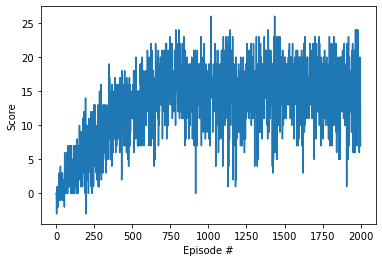

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Evaluate the agent

We will then observe the trained behavior of the DQN agent ands finally record the total score. This next cell will load the saved model and then we can test the model on the env.


In [6]:
agent = DQNAgent(state_size, action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('lowdim.pth'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,432
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
FCQNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


Episode 100	Average Score: 11.82	Score: 16.00
Episode 200	Average Score: 12.51	Score: 15.00


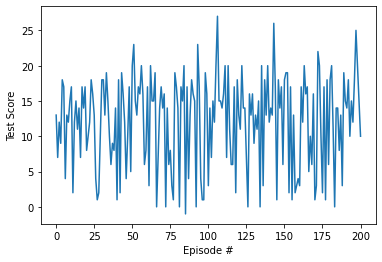

In [8]:
def test_dqn(n_episodes=200, max_t=1000, start_episode=1, print_every=100):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(start_episode, start_episode+n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            # get the current state
        score = 0 
        
        for t in range(max_t):
            action = agent.act(state)                      # select an action
            env_info = env.step(action.astype(np.int32))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
    
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, score))
    return scores

test_scores = test_dqn()

# plotting the test scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(test_scores)), test_scores)
plt.ylabel('Test Score')
plt.xlabel('Episode #')
plt.show()

Due to stochasticity of the environment, sometime we can see many blue bananas surrounding the agent, it then oscillates in these situations. Overall, the mean score reaches the target to solve this environment. Finally, we can enjoy watching our trained agent!

In [10]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action.astype(np.int32))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 14.0


In [11]:
env.close()